In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import sklearn
import seaborn as sns
import statsmodels.api as sm

from mpl_toolkits.mplot3d import Axes3D
from numpy import histogram_bin_edges
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.regressionplots import plot_partregress_grid


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic
!jupyter nbconvert --to pdf /content/Final_Project.ipynb

Reading package lists... Done
Building dependency tree       
Reading state information... Done
texlive-fonts-recommended is already the newest version (2017.20180305-1).
texlive-plain-generic is already the newest version (2017.20180305-2).
texlive-xetex is already the newest version (2017.20180305-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 27 not upgraded.
[NbConvertApp] Converting notebook /content/Final_Project.ipynb to pdf
[NbConvertApp] Support files will be in Final_Project_files/
[NbConvertApp] Making directory ./Final_Project_files
[NbConvertApp] Making directory ./Final_Project_files
[NbConvertApp] Making directory ./Final_Project_files
[NbConvertApp] Making directory ./Final_Project_files
[NbConvertApp] Making directory ./Final_Project_files
[NbConvertApp] Making directory ./Final_Project_files
[NbConvertApp] Making directory ./F

In [ ]:
df = pd.read_csv('/content/drive/Shareddrives/AAI500 Final Project/redfin_2022_san_diego.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 27 columns):
 #   Column                                                                                       Non-Null Count  Dtype  
---  ------                                                                                       --------------  -----  
 0   SALE TYPE                                                                                    300 non-null    object 
 1   SOLD DATE                                                                                    0 non-null      float64
 2   PROPERTY TYPE                                                                                300 non-null    object 
 3   ADDRESS                                                                                      297 non-null    object 
 4   CITY                                                                                         300 non-null    object 
 5   STATE OR PROVINCE                   

In [ ]:
df = df.drop(['SALE TYPE', 'SOLD DATE', 'STATUS', 'ADDRESS', 'CITY', 'LOCATION', 'STATE OR PROVINCE', 'NEXT OPEN HOUSE START TIME', 'NEXT OPEN HOUSE END TIME', 'URL (SEE https://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING)', 'SOURCE', 'MLS#', 'FAVORITE', 'INTERESTED'], axis=1)

In [ ]:
new_column_names = [
    'property_type',
    'zip',
    'price',
    'beds',
    'baths',
    'sq_feet',
    'lot_size',
    'yr_built',
    'days_market',
    'price_per_sqft',
    'hoa_month',
    'latitude',
    'longitude'
    ]
df.columns = new_column_names

# **General Functions**

**Clean Data**

*   Removes Data not significant for our model
*   Removes outliers
*   Creates a new column home_age







In [ ]:
def clean_data(raw_data, array_of_columns_to_analyze):
  ## drop data that is irrelevant or unhelpful
  raw_data = raw_data.drop(['price_per_sqft', 'days_market'], axis=1)

  ## drop Vacant Land, since it's too different of an asset
  raw_data.drop(raw_data[raw_data.property_type == 'Vacant Land'].index, inplace=True)

  ## remove N/A
  raw_data.beds.fillna(1, inplace=True)
  raw_data.baths.fillna(1, inplace=True)
  raw_data.sq_feet.fillna(method='bfill', inplace=True)
  raw_data.yr_built.fillna(2022, inplace=True)
  raw_data.hoa_month.fillna(0, inplace=True)
  raw_data.lot_size.fillna(0,inplace=True)

  ## transform year built to age of home
  raw_data['home_age'] = 2022 - raw_data.yr_built
  raw_data = raw_data.drop('yr_built', axis=1)

  ## remove outliers entries
  df_numeric = raw_data.drop(['property_type', 'zip'], axis=1)
  df_no_outliers = raw_data[np.abs(stats.zscore(df_numeric) < 2.5).all(axis=1)]

  ## include only columns of interest
  return df_no_outliers[array_of_columns_to_analyze]

**Get Dummies for categorical columns**

*   Categorical columns get converted to dummy variables
*   Creates new categorical columns from numerical values such as home age


In [ ]:
def get_dummies_for_categoricals(data):
  if 'property_type' in data.columns:
    data = pd.get_dummies(data, columns = ['property_type'], drop_first=True)
  if 'zip' in data.columns:
    data = pd.get_dummies(data, columns = ['zip'], drop_first=True)
  if 'beds' in data.columns:
    data['beds_baths'] = data['beds'] + data['baths']
    data = data.drop(['beds', 'baths'], axis=1)
  if 'home_age' in data.columns:
    data.loc[data['home_age'] >= 50, 'home_age'] = 50
    data.loc[data['home_age'] < 50, 'home_age'] = 20
    data = pd.get_dummies(data, columns = ['home_age'], drop_first=True)
  if 'longitude' in data.columns:
    data['location'] = data['longitude']
    data.loc[(data.longitude <= -117.1) & (data.latitude < 32.9), 'location'] = 1
    data.loc[(data.longitude > -117.1) & (data.latitude < 32.9), 'location'] = 2
    data.loc[data.latitude >= 32.9, 'location'] = 3
    data = data.drop(['latitude', 'longitude'], axis=1)
    data = pd.get_dummies(data, columns = ['location'], drop_first=True)
  if 'hoa_month' in data.columns:
    data.loc[data['hoa_month'] >= 1000, 'hoa_month'] = 1000
    data.loc[(data['hoa_month'] > 0) & (data['hoa_month'] < 1000), 'hoa_month'] = 400
    data.loc[data['hoa_month'] == 0, 'hoa_month'] = 0
    data = pd.get_dummies(data, columns = ['hoa_month'], drop_first=True)
  if 'lot_size' in data.columns:
    data.loc[data['lot_size'] >= 8000, 'lot_size'] = 8000
    data.loc[(data['lot_size'] > 0) & (data['lot_size'] < 8000), 'lot_size'] = 6000
    data.loc[data['lot_size'] == 0, 'lot_size'] = 0
    data = pd.get_dummies(data, columns = ['lot_size'], drop_first=True)

  return data

**Normalize and Split Data**

*   Splits the dataframe into a 20% test and 80% training data
*   Normalize numerical columns price and square feet
*   Calls get_dummies_for_categoricals on data



In [ ]:
def split_data_and_normalize(data):
  ## Seperate dependent from independent
  X = data.drop(['price'], axis=1)
  y = data.price

  ## get dummies for categorical data
  X = get_dummies_for_categoricals(X)

  ## normalize data
  y = np.log(y)
  X.sq_feet = np.log(X.sq_feet)

  ## split into train and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 40)

  return X_train, X_test, y_train, y_test

**Create Linear Model**

*   Calls split_data_and_normalize function on data
*   Trains the model using sklearn with the training data
*   Returns all the training and test data with the linear model and score



In [ ]:
def create_linear_model(data):
  X_train, X_test, y_train, y_test = split_data_and_normalize(data)

  ## train regression model on training data
  linear_model = LinearRegression()
  linear_model.fit(X_train, y_train)

  ## Make predictions using the testing set
  y_pred = linear_model.predict(X_test)

  ## return R squared metric
  return y_pred, y_test, y_train, X_test, X_train, linear_model.score(X_test, y_test), linear_model

**Get OLS metric**

*   Splits the data and normalizes to then train it using OLS
*   Prints out the summary of the linear model





In [ ]:
def get_ols_metrics(data):
  X_train, X_test, y_train, y_test = split_data_and_normalize(data)

  stat_model = sm.OLS(y_train, X_train).fit()
  print(stat_model.summary())

# **Basic visualization of the data**

In [ ]:
df.head()

,property_type,zip,price,beds,baths,sq_feet,lot_size,yr_built,days_market,price_per_sqft,hoa_month,latitude,longitude
0,Condo/Co-op,92037,1150000,3.0,2.5,1707.0,155945.0,1978.0,13.0,674.0,495.0,32.858687,-117.231625
1,Single Family Residential,91942,759000,3.0,2.0,1018.0,6100.0,1958.0,27.0,746.0,NaN,32.780982,-117.020159
2,Townhouse,92037,829900,2.0,2.5,1140.0,NaN,1975.0,40.0,728.0,509.0,32.861255,-117.231921
3,Condo/Co-op,92037,875000,2.0,2.5,1074.0,103585.0,1977.0,42.0,815.0,400.0,32.859532,-117.233455
4,Single Family Residential,92127,1195000,4.0,3.0,2284.0,10259.0,1981.0,48.0,523.0,107.0,33.009474,-117.083660


**Checks all empty values for all columns**

In [ ]:
df.isnull().sum()

property_type       0
zip                 0
price               0
beds                5
baths              10
sq_feet            10
lot_size          101
yr_built           14
days_market         4
price_per_sqft     10
hoa_month         127
latitude            0
longitude           0
dtype: int64

*   **Make of a copy of raw data for comparison**
*   **Cleans Data for visualization**



In [ ]:
df_raw = df.copy()
df = clean_data(df, ['property_type', 'zip', 'price', 'beds', 'baths', 'sq_feet', 'home_age', 'hoa_month', 'latitude', 'longitude'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 262 entries, 0 to 299
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   property_type  262 non-null    object 
 1   zip            262 non-null    int64  
 2   price          262 non-null    int64  
 3   beds           262 non-null    float64
 4   baths          262 non-null    float64
 5   sq_feet        262 non-null    float64
 6   home_age       262 non-null    float64
 7   hoa_month      262 non-null    float64
 8   latitude       262 non-null    float64
 9   longitude      262 non-null    float64
dtypes: float64(7), int64(2), object(1)
memory usage: 22.5+ KB


In [ ]:
df.describe()

,zip,price,beds,baths,sq_feet,home_age,hoa_month,latitude,longitude
count,262.000000,2.620000e+02,262.000000,262.000000,262.000000,262.000000,262.000000,262.000000,262.000000
mean,92054.061069,2.338521e+06,3.408397,2.992366,2473.637405,36.706107,223.431298,32.889517,-117.167869
std,65.198989,2.006316e+06,1.388653,1.466725,1604.331200,22.821846,250.276600,0.093175,0.091597
min,91942.000000,3.690000e+05,0.000000,1.000000,432.000000,0.000000,0.000000,32.759038,-117.281220
25%,92037.000000,8.350000e+05,2.000000,2.000000,1246.250000,17.000000,0.000000,32.818099,-117.253726
50%,92037.000000,1.520000e+06,3.000000,2.500000,1916.000000,36.500000,159.000000,32.854934,-117.166432
75%,92127.000000,3.035750e+06,4.000000,3.500000,3365.250000,53.000000,397.000000,32.998244,-117.095911
max,92127.000000,1.050000e+07,7.000000,7.500000,7722.000000,90.000000,1183.000000,33.040174,-116.987657


**Graphs all comparisons with all the variables in the clean data**

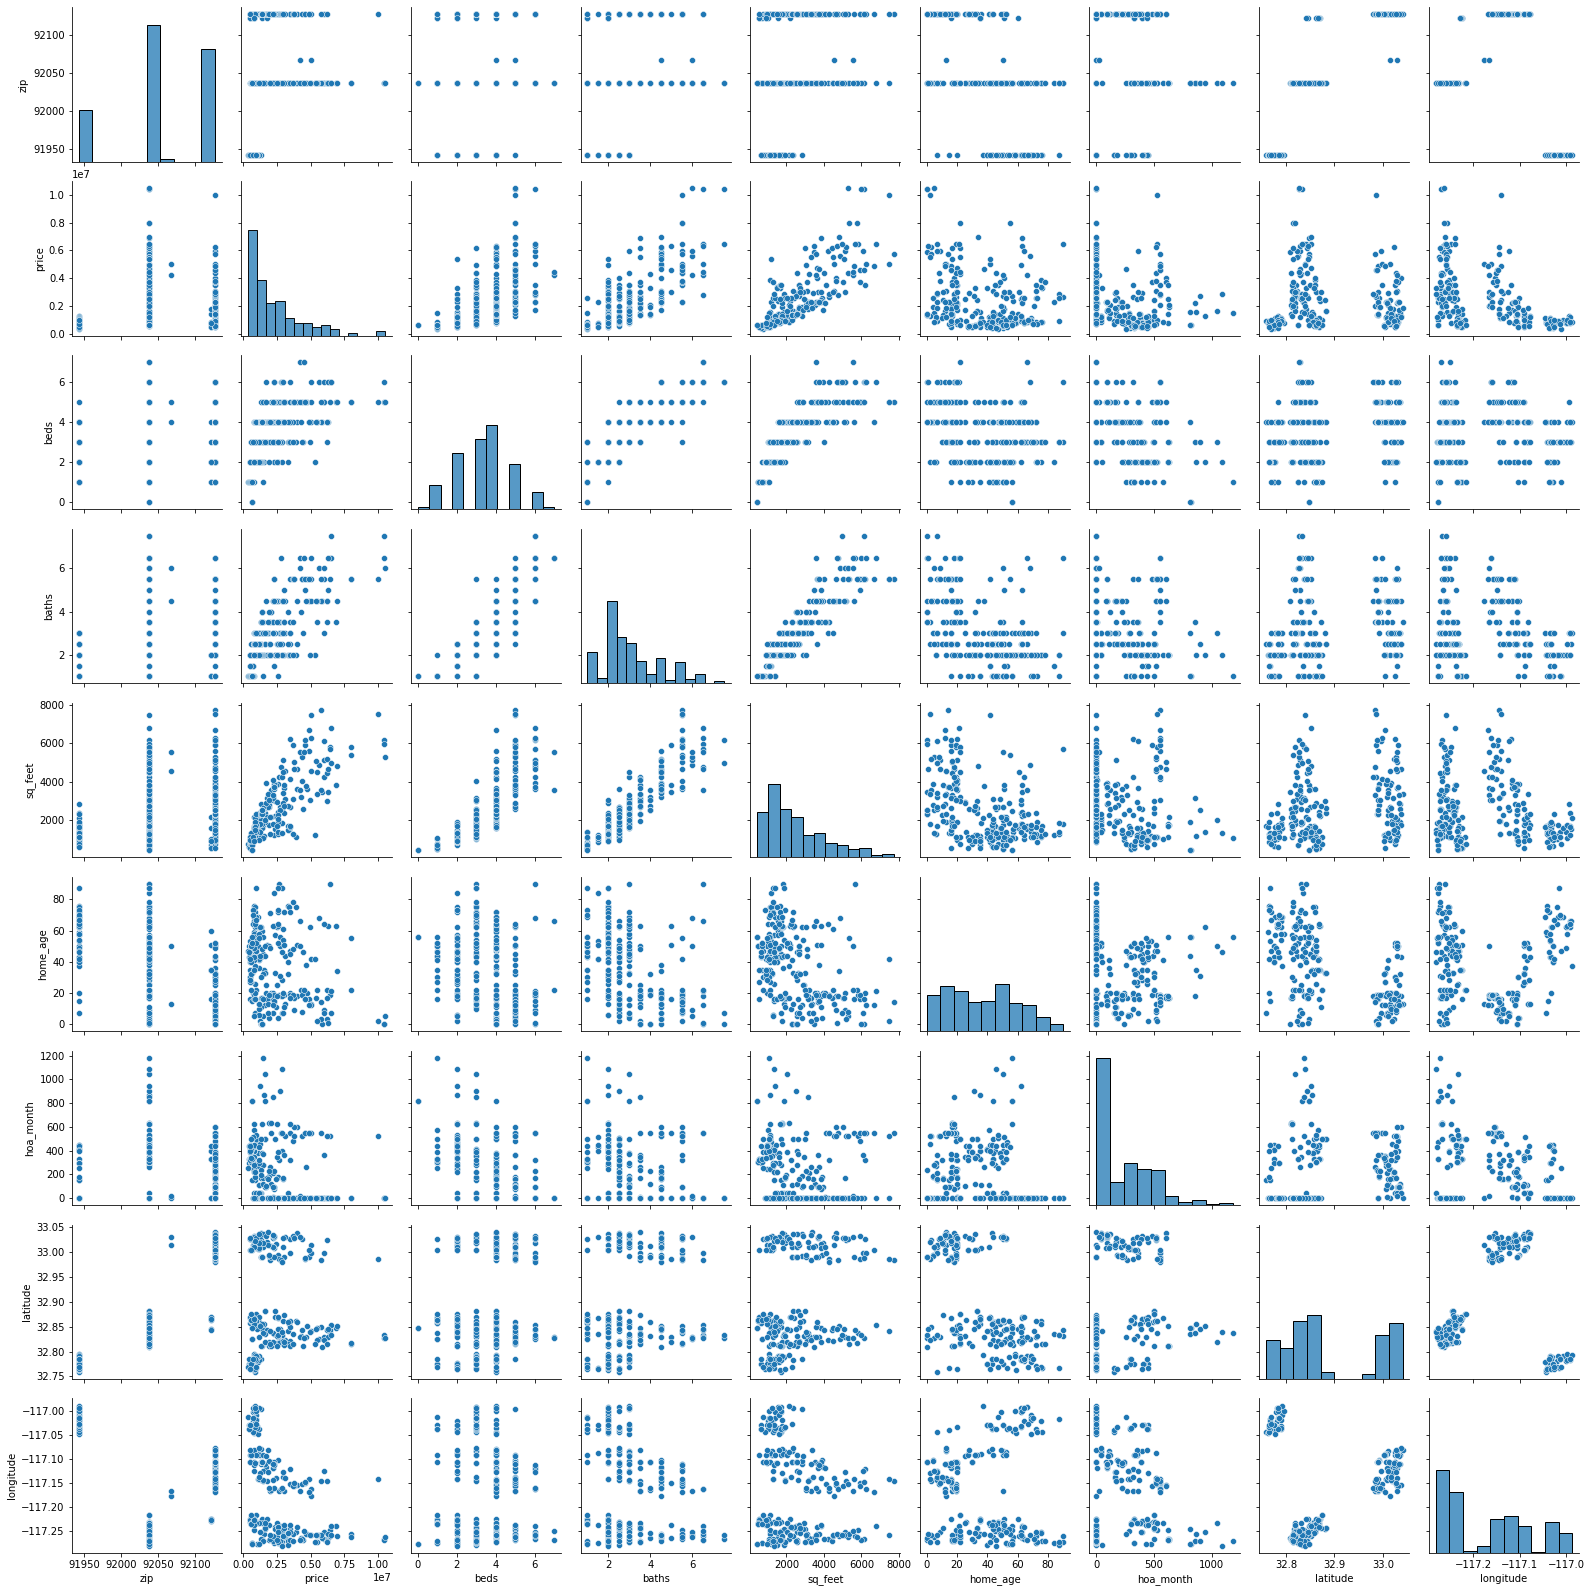

In [ ]:
sns.pairplot(df)
plt.show()

**This graph demonstrates 3 primary locations the houses are located**

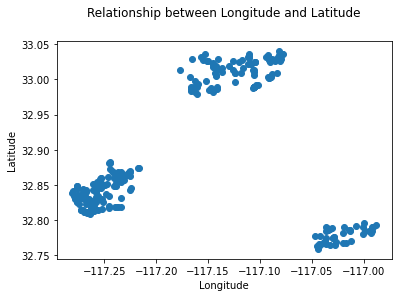

In [ ]:
plt.scatter(df.longitude, df.latitude)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Relationship between Longitude and Latitude",pad=25)
plt.show()

**Following two graphs shows price and square feet with and without normalization**

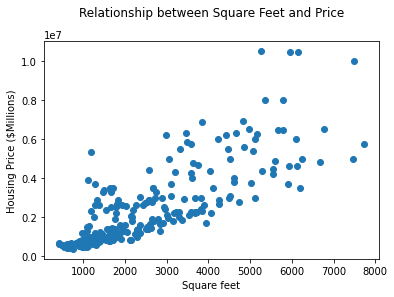

In [ ]:
plt.scatter(df['sq_feet'], df['price'])
plt.xlabel("Square feet")
plt.ylabel("Housing Price ($Millions)")
plt.title("Relationship between Square Feet and Price",pad=25)
plt.show()

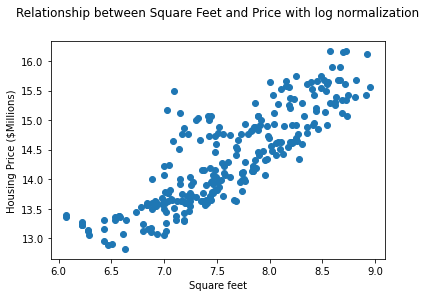

In [ ]:
plt.scatter(np.log(df['sq_feet']), np.log(df['price']))
plt.xlabel("Square feet")
plt.ylabel("Housing Price ($Millions)")
plt.title("Relationship between Square Feet and Price with log normalization",pad=25)
plt.show()

**Following graphs show comparison between beds, baths, and price**

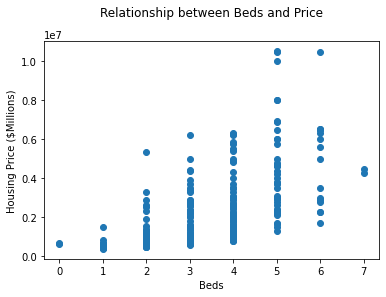

In [ ]:
plt.scatter(df['beds'], np.log(df['price']))
plt.xlabel("Beds")
plt.ylabel("Housing Price ($Millions)")
plt.title("Relationship between Beds and Price",pad=25)
plt.show()

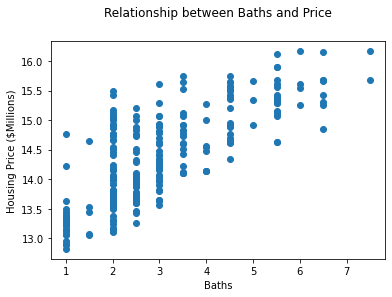

In [ ]:
plt.scatter(df['baths'], np.log(df['price']))
plt.xlabel("Baths")
plt.ylabel("Housing Price ($Millions)")
plt.title("Relationship between Baths and Price",pad=25)
plt.show()

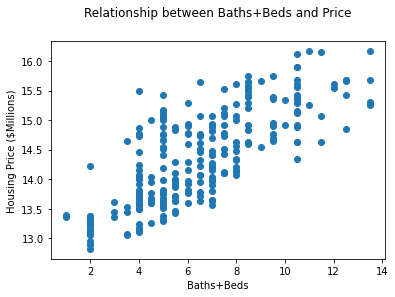

In [ ]:
plt.scatter(df['baths'] + df['beds'], np.log(df['price']))
plt.xlabel("Baths+Beds")
plt.ylabel("Housing Price ($Millions)")
plt.title("Relationship between Baths+Beds and Price",pad=25)
plt.show()

**Following graphs show comparison between home age and price**

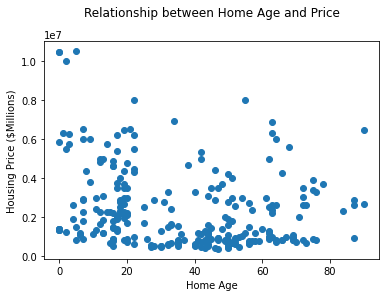

In [ ]:
plt.scatter(df['home_age'], df['price'])
plt.xlabel("Home Age")
plt.ylabel("Housing Price ($Millions)")
plt.title("Relationship between Home Age and Price",pad=25)
plt.show()

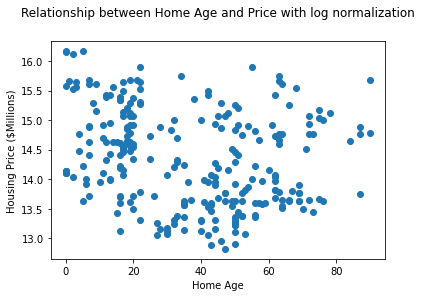

In [ ]:
plt.scatter(df['home_age'], np.log(df['price']))
plt.xlabel("Home Age")
plt.ylabel("Housing Price ($Millions)")
plt.title("Relationship between Home Age and Price with log normalization",pad=25)
plt.show()

# **Checking Distributions of Numerical Variables**

**Checking Distribution for Price**

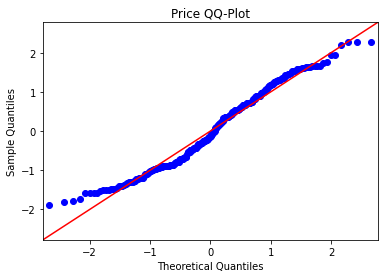

In [ ]:
fig = sm.qqplot(np.log(df['price']), line = '45', fit = True)
plt.title("Price QQ-Plot")
plt.show()

Text(0.5, 1.0, 'Price PDF Before Data Cleaning')

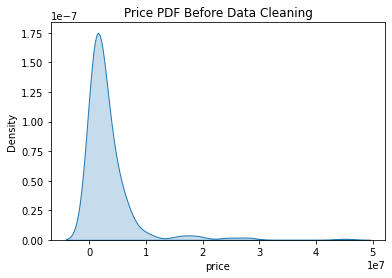

In [ ]:
ax = sns.kdeplot(data = df_raw['price'], shade = True)
ax.grid(False)
plt.title("Price PDF Before Data Cleaning")

Text(0.5, 1.0, 'Price PDF After Data Cleaning')

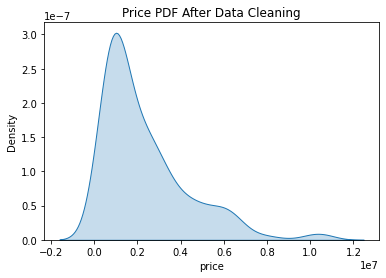

In [ ]:
ax = sns.kdeplot(data = df['price'], shade = True)
ax.grid(False)
plt.title("Price PDF After Data Cleaning")

**Checking Distribution for Square Feet**

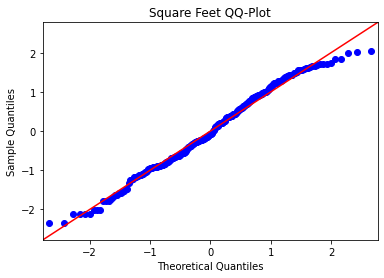

In [ ]:
fig = sm.qqplot(np.log(df['sq_feet']), line = '45', fit = True)
plt.title("Square Feet QQ-Plot")
plt.show()

Text(0.5, 1.0, 'Square Feet PDF Before Data Cleaning')

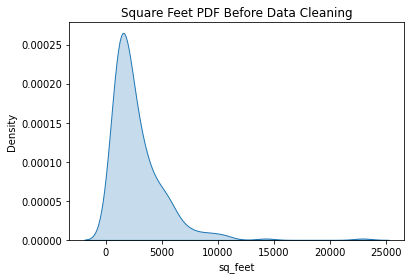

In [ ]:
ax = sns.kdeplot(data = df_raw['sq_feet'], shade = True)
ax.grid(False)
plt.title("Square Feet PDF Before Data Cleaning")

Text(0.5, 1.0, 'Square Feet PDF After Data Cleaning')

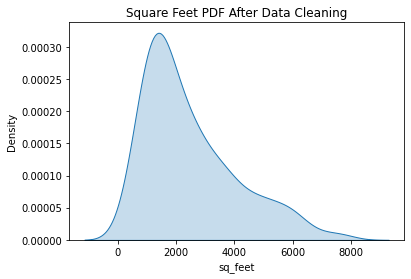

In [ ]:
ax = sns.kdeplot(data = df['sq_feet'], shade = True)
ax.grid(False)
plt.title("Square Feet PDF After Data Cleaning")

**Checking Distribution for Home Age**

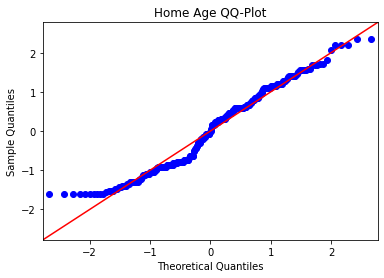

In [ ]:
fig = sm.qqplot(df['home_age'], line = '45', fit = True)
plt.title("Home Age QQ-Plot")
plt.show()

Text(0.5, 1.0, 'Home Age PDF Before Data Cleaning')

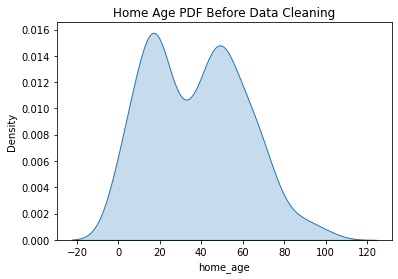

In [ ]:
df_raw['home_age'] = 2022 - df_raw.yr_built
df_raw = df_raw.drop('yr_built', axis=1)
ax = sns.kdeplot(data = df_raw['home_age'], shade = True)
ax.grid(False)
plt.title("Home Age PDF Before Data Cleaning")

Text(0.5, 1.0, 'Home Age PDF After Data Cleaning')

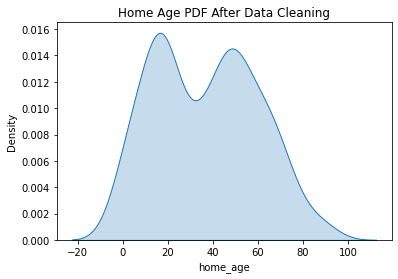

In [ ]:
ax = sns.kdeplot(data = df['home_age'], shade = True)
ax.grid(False)
plt.title("Home Age PDF After Data Cleaning")

**Checking Distribution for Longitude and Latitude**

Text(0.5, 1.0, 'Longitude PDF Before Data Cleaning')

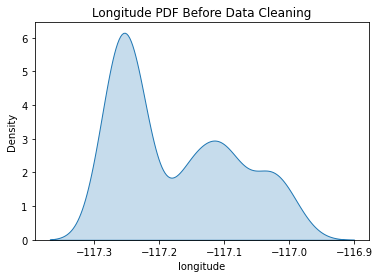

In [ ]:

ax = sns.kdeplot(data = df_raw['longitude'], shade = True)
ax.grid(False)
plt.title("Longitude PDF Before Data Cleaning")

Text(0.5, 1.0, 'Longitude PDF After Data Cleaning')

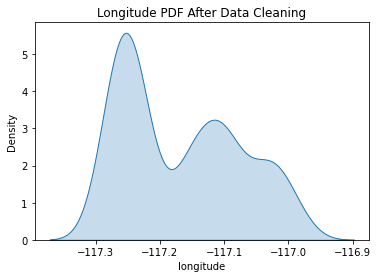

In [ ]:
ax = sns.kdeplot(data = df['longitude'], shade = True)
ax.grid(False)
plt.title("Longitude PDF After Data Cleaning")

Text(0.5, 1.0, 'Latitude PDF Before Data Cleaning')

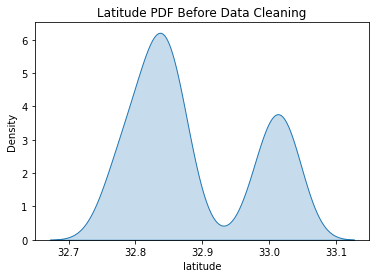

In [ ]:
ax = sns.kdeplot(data = df_raw['latitude'], shade = True)
ax.grid(False)
plt.title("Latitude PDF Before Data Cleaning")

Text(0.5, 1.0, 'Latitude PDF After Data Cleaning')

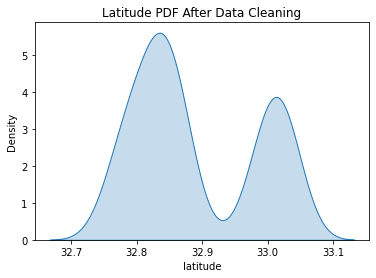

In [ ]:
ax = sns.kdeplot(data = df['latitude'], shade = True)
ax.grid(False)
plt.title("Latitude PDF After Data Cleaning")

**Checking Frequency of Property Type and Zip**

Text(0.5, 1.0, 'Frequency of Property Type')

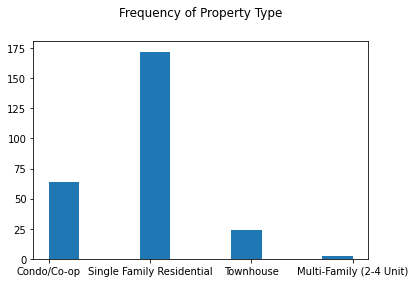

In [ ]:
plt.hist(df['property_type'], bins = 'auto')
plt.title("Frequency of Property Type", pad=25)

Text(0.5, 1.0, 'Frequency of Zip')

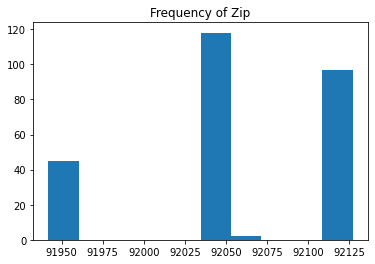

In [ ]:
plt.hist(df['zip'], bins = 'auto')
plt.title("Frequency of Zip")

# **3D Relationships between Variables**

**Following graphs shows how relationship with variables changes as one adds another variable**

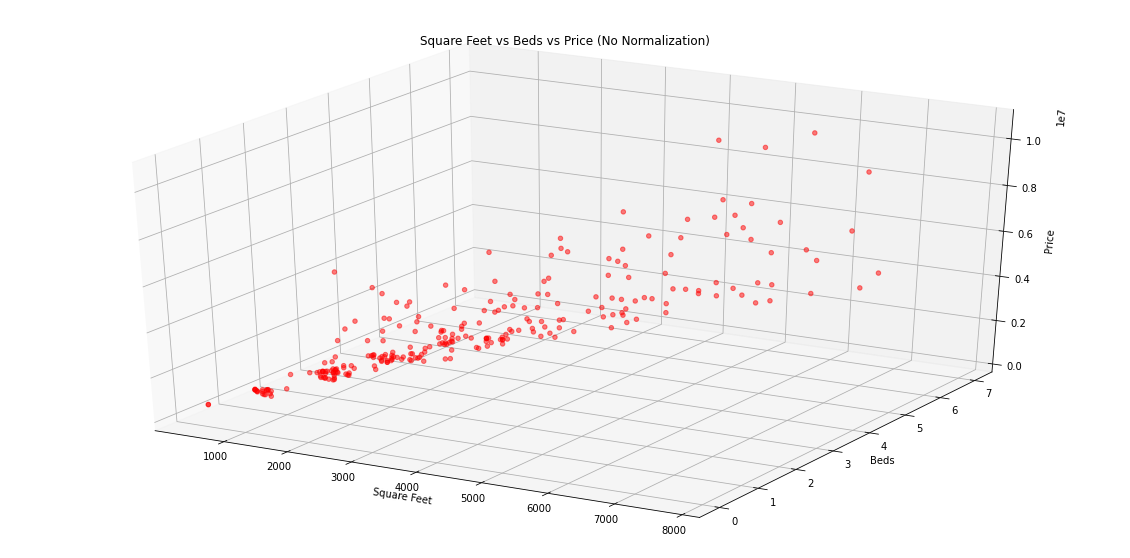

In [ ]:
fig = plt.figure(figsize=(20,10))
### Set figure size
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['sq_feet'], df['beds'], df['price'], c='red', marker='o', alpha=0.5)
ax.set_xlabel('Square Feet')
ax.set_ylabel('Beds')
ax.set_zlabel('Price')
plt.title("Square Feet vs Beds vs Price (No Normalization)")
plt.show()

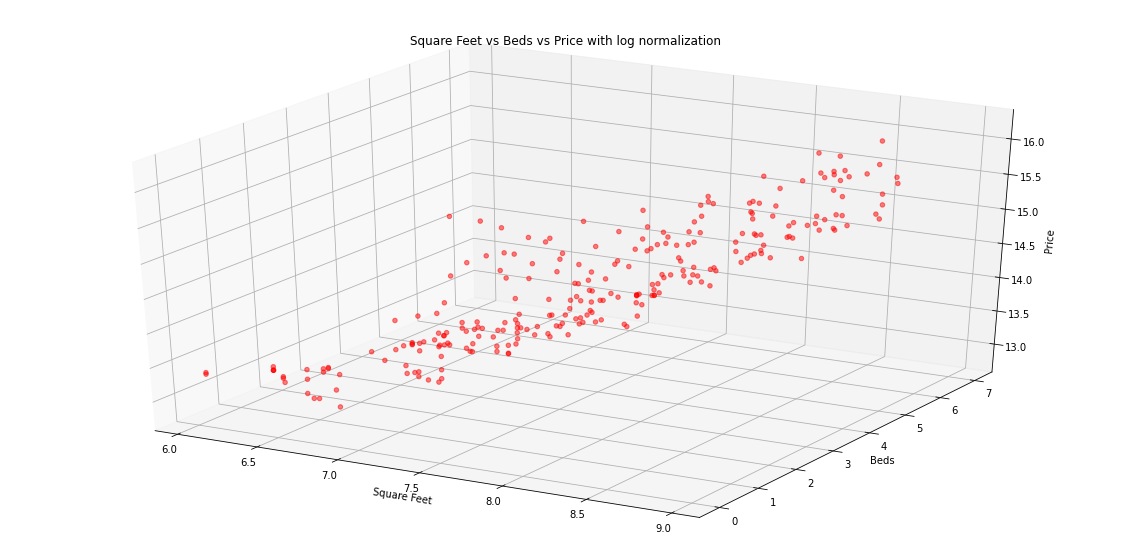

In [ ]:
fig = plt.figure(figsize=(20,10))
### Set figure size
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.log(df['sq_feet']), df['beds'], np.log(df['price']), c='red', marker='o', alpha=0.5)
ax.set_xlabel('Square Feet')
ax.set_ylabel('Beds')
ax.set_zlabel('Price')
plt.title("Square Feet vs Beds vs Price with log normalization")
plt.show()

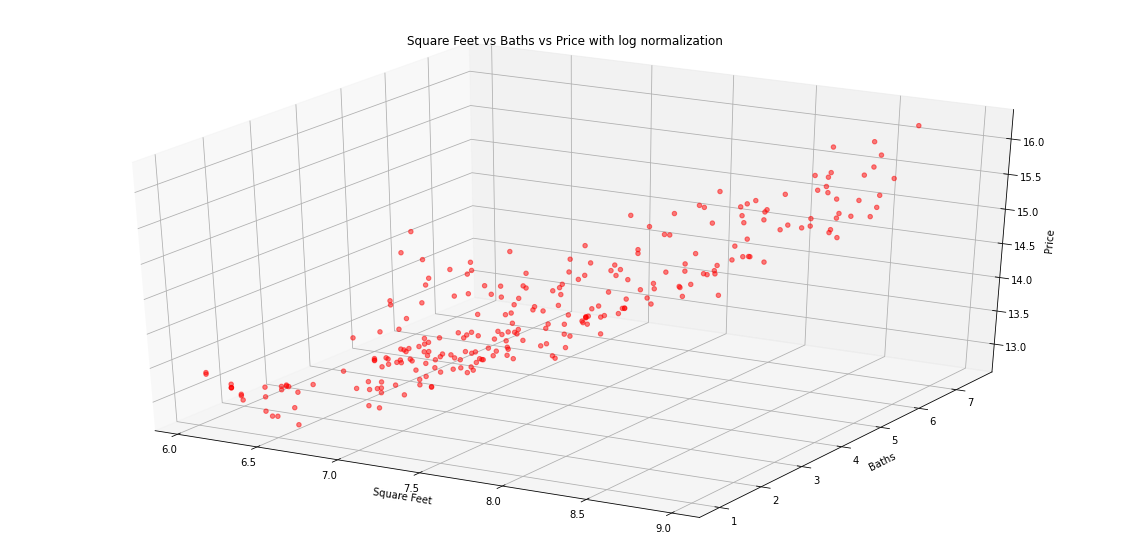

In [ ]:
fig = plt.figure(figsize=(20,10))
### Set figure size
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.log(df['sq_feet']), df['baths'], np.log(df['price']), c='red', marker='o', alpha=0.5)
ax.set_xlabel('Square Feet')
ax.set_ylabel('Baths')
ax.set_zlabel('Price')
plt.title("Square Feet vs Baths vs Price with log normalization")
plt.show()

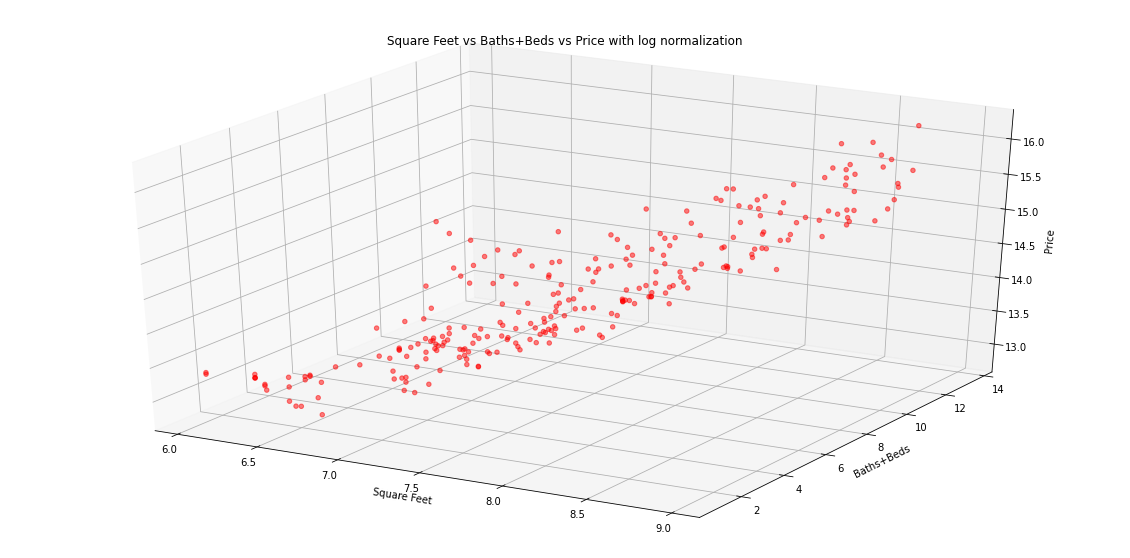

In [ ]:
fig = plt.figure(figsize=(20,10))
### Set figure size
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.log(df['sq_feet']), df['baths']+df['beds'], np.log(df['price']), c='red', marker='o', alpha=0.5)
ax.set_xlabel('Square Feet')
ax.set_ylabel('Baths+Beds')
ax.set_zlabel('Price')
plt.title("Square Feet vs Baths+Beds vs Price with log normalization")
plt.show()

**Demonstrates that with the presence of square feet and home age, there is a linear relationship with price**

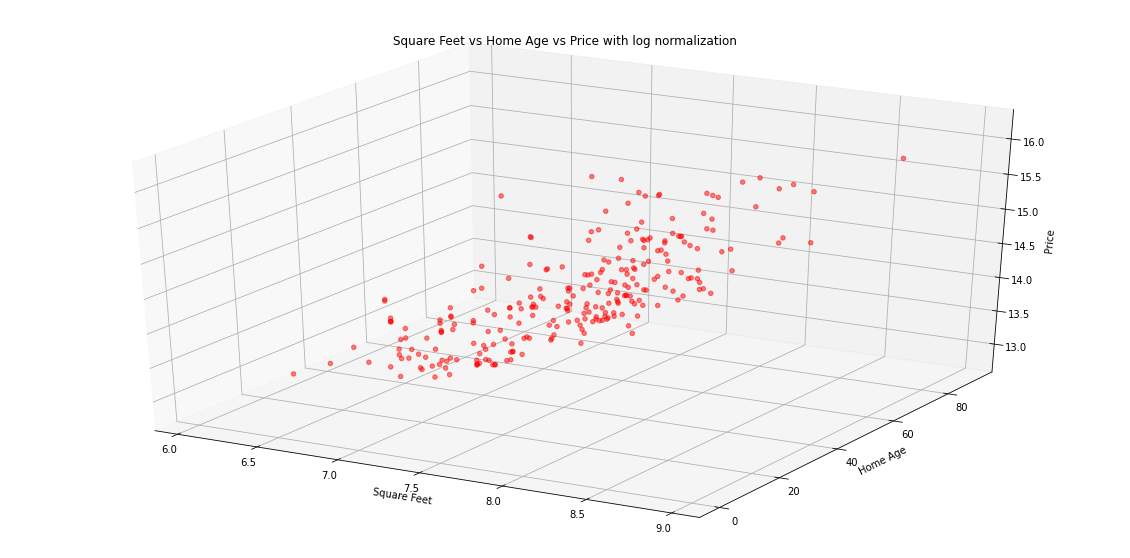

In [ ]:
fig = plt.figure(figsize=(20,10))
### Set figure size
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.log(df['sq_feet']), df['home_age'], np.log(df['price']), c='red', marker='o', alpha=0.5)
ax.set_xlabel('Square Feet')
ax.set_ylabel('Home Age')
ax.set_zlabel('Price')
plt.title("Square Feet vs Home Age vs Price with log normalization")
plt.show()

# **Checking for Multicollernarity**

**Test the correlation between all categorical and numerical variables**

In [ ]:
df_cat = get_dummies_for_categoricals(df)
column_names = ['price', 'sq_feet', 'property_type_1',
       'property_type_2', 'property_type_3',
       'zip_92037', 'zip_92067', 'zip_92122', 'zip_92127', 'beds_baths',
       'home_age_70', 'location_2', 'location_3', 'hoa_month_400',
       'hoa_month_1000']
df_cat.columns = column_names
df_cat.price = np.log(df_cat.price)
df_cat.sq_feet = np.log(df_cat.sq_feet)

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


         VIF         variable
0   0.000000        Intercept
1   8.620012          sq_feet
2   1.190959  property_type_1
3   4.103789  property_type_2
4   1.302824  property_type_3
5        inf        zip_92037
6        inf        zip_92067
7        inf        zip_92122
8        inf        zip_92127
9   7.083782       beds_baths
10  1.770591      home_age_70
11       inf       location_2
12       inf       location_3
13  2.915055    hoa_month_400
14  1.149375   hoa_month_1000


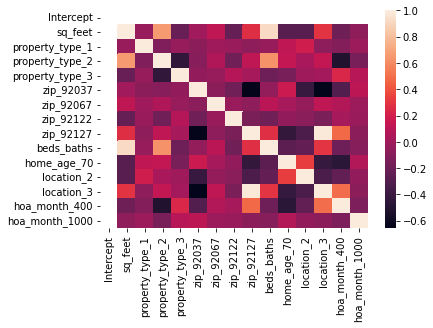

In [ ]:
formula = 'price ~sq_feet+property_type_1+property_type_2+property_type_3+zip_92037+zip_92067+zip_92122+zip_92127+beds_baths+home_age_70+location_2+location_3+hoa_month_400+hoa_month_1000'
y, X = dmatrices(formula, data=df_cat, return_type='dataframe')

#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

#view VIF for each explanatory variable
print(vif)

cormat = X.corr()
round(cormat,2)
sns.heatmap(cormat);
plt.show()

**Tested correlation again after removing variables that demonstrated high vif values and correlation**

          VIF         variable
0  327.378837        Intercept
1    2.674356          sq_feet
2    1.189160  property_type_1
3    4.092535  property_type_2
4    1.297852  property_type_3
5    1.697040      home_age_70
6    1.363311       location_2
7    2.036589       location_3
8    2.863542    hoa_month_400
9    1.133111   hoa_month_1000


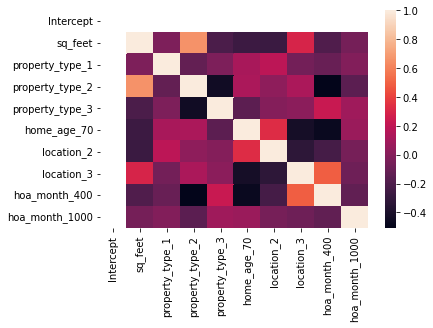

In [ ]:
formula = 'price ~ sq_feet+property_type_1+property_type_2+property_type_3+home_age_70+location_2+location_3+hoa_month_400+hoa_month_1000'
y, X = dmatrices(formula, data=df_cat, return_type='dataframe')

#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

#view VIF for each explanatory variable
print(vif)

cormat = X.corr()
round(cormat,2)
sns.heatmap(cormat);
plt.show()

# **Model 1**
**Included all variables with lower vif scores**

In [ ]:
selected_columns = df[['property_type', 'sq_feet', 'home_age', 'hoa_month', 'longitude', 'latitude', 'price']]
df_1 = selected_columns.copy()
y_pred, y_test, y_train, X_test, X_train, score, linear_model = create_linear_model(df_1)
print(df_1.columns, score)

Index(['property_type', 'sq_feet', 'home_age', 'hoa_month', 'longitude',
       'latitude', 'price'],
      dtype='object') 0.9214605248167189


In [ ]:
print('Intercept: \n', linear_model.intercept_)
print('Coefficients: \n', linear_model.coef_)

Intercept: 
 7.8575450028975995
Coefficients: 
 [ 0.87726274  0.16109537  0.27645524 -0.06021523  0.00281664 -0.79804229
 -0.51559836 -0.08773005  0.46609218]


In [ ]:
X_train = sm.add_constant(X_train)
stat_model = sm.OLS(y_train, X_train).fit()

print(stat_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     176.8
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           7.25e-90
Time:                        05:36:48   Log-Likelihood:                -21.180
No. Observations:                 209   AIC:                             62.36
Df Residuals:                     199   BIC:                             95.78
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


          VIF         variable
0  313.191716        Intercept
1    2.628543          sq_feet
2    1.241856  property_type_1
3    4.263288  property_type_2
4    1.313501  property_type_3
5    1.783333      home_age_40
6    1.431263       location_2
7    2.230255       location_3
8    3.091312    hoa_month_400
9    1.124332   hoa_month_1000


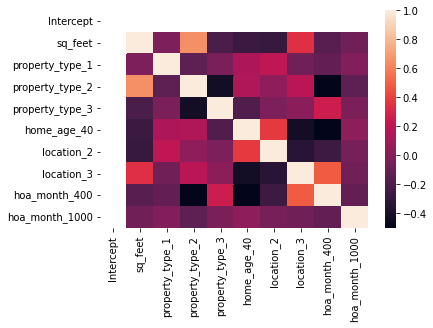

In [ ]:
train = pd.concat([y_train, X_train], axis=1)
columns_names = ['price', 'const', 'sq_feet','property_type_1','property_type_2','property_type_3', 'home_age_40', 'location_2', 'location_3', 'hoa_month_400', 'hoa_month_1000']
train.columns = columns_names

formula = 'price ~ sq_feet+property_type_1+property_type_2+property_type_3+home_age_40+location_2+location_3+hoa_month_400+hoa_month_1000'
y, X = dmatrices(formula, data=train, return_type='dataframe')

#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

#view VIF for each explanatory variable
print(vif)

cormat = X.corr()
round(cormat,2)
sns.heatmap(cormat);
plt.show()

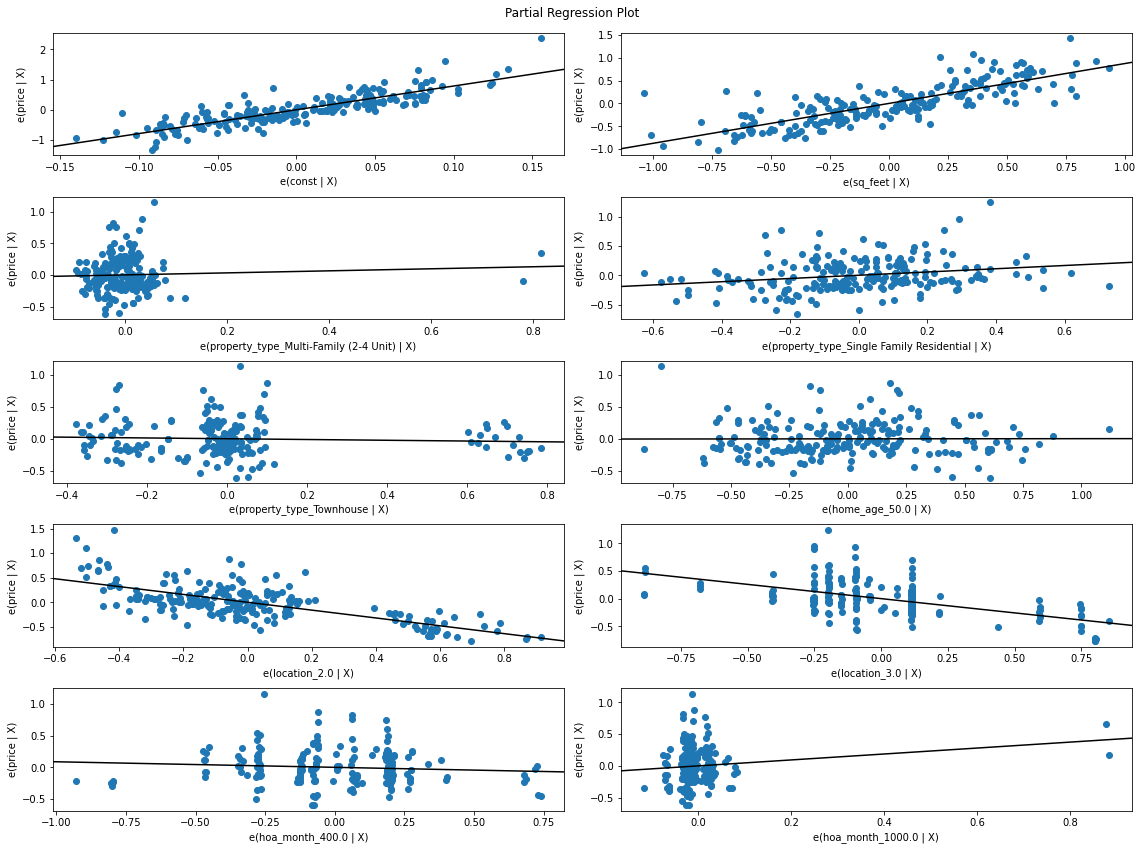

In [ ]:
fig = plt.figure(figsize=(16, 12))
plot_partregress_grid(stat_model, fig=fig)
plt.show()

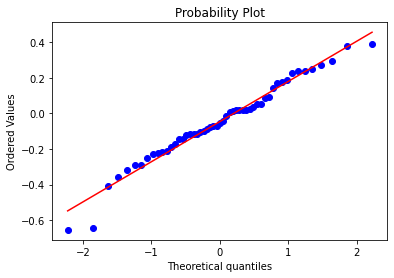

In [ ]:
residuals = np.array([])
for i, y in np.ndenumerate(y_test):
  residuals = np.append(residuals, y - y_pred[i])
stats.probplot(residuals, plot=plt)
plt.show()

Text(0.5, 1.0, 'Fit Values for Residuals: -0.05 and 0.22')

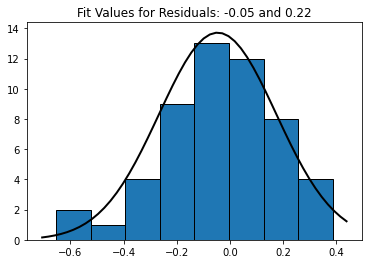

In [ ]:
mu, std = stats.norm.fit(residuals)

plt.hist(residuals, edgecolor = 'black', bins = 'sqrt')
# Plot the PDF.
xmin, xmax = plt.xlim()
bin_width = (xmax-xmin)/8
x = np.linspace(xmin, xmax, 50)
p = stats.norm.pdf(x, mu, std)

plt.plot(x, p*residuals.size*bin_width, 'k', linewidth=2)
title = "Fit Values for Residuals: {:.2f} and {:.2f}".format(mu, std)
plt.title(title)

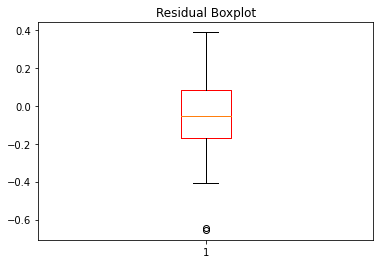

In [ ]:
plt.boxplot(residuals, boxprops=dict(color='red'))
plt.title('Residual Boxplot');

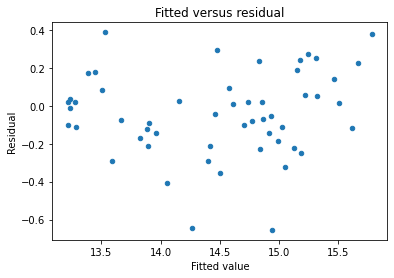

In [ ]:
residuals = np.array([])
fitted = np.array([])
for i, y in np.ndenumerate(y_test):
  residuals = np.append(residuals, y - y_pred[i])
  fitted = np.append(fitted, y_pred[i])

df_residuals = {}
df_residuals['x'] = fitted
df_residuals['y'] = residuals
df_residuals = pd.DataFrame(df_residuals)

ax = df_residuals.plot.scatter('x', 'y')
ax.set_title('Fitted versus residual')
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
plt.show()

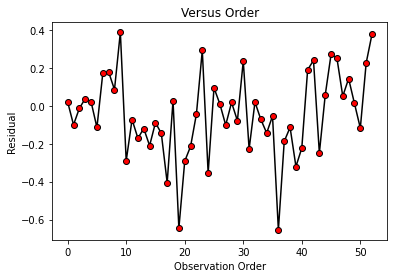

In [ ]:
keyed_values = sorted(zip(df_residuals['x'], df_residuals['y']), key=lambda x: x[ 0])
sorted_residuals = [x[ 1] for x in keyed_values]
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(sorted_residuals, 'ro-', c='black', mfc='red')
ax.set_title('Versus Order')
ax.set_xlabel('Observation Order')
ax.set_ylabel('Residual')
plt.show()

In [ ]:
df_actual_v_predicted = {}
df_actual_v_predicted['Sq Ft'] = np.exp(X_test.sq_feet).round(0).astype(int)
df_actual_v_predicted['Actual'] = np.exp(y_test).round(0).astype(int)
df_actual_v_predicted['Predicted'] = np.exp(y_pred).round(0).astype(int)
df_actual_v_predicted['Difference'] = (np.exp(y_test).round(0).astype(int) - np.exp(y_pred).round(0).astype(int))
df_actual_v_predicted = pd.DataFrame(df_actual_v_predicted)

In [ ]:
pd.set_option('max_colwidth', 600)
display(df_actual_v_predicted.sort_values(by='Actual'))

,Sq Ft,Actual,Predicted,Difference
200,899,499000,551683,-52683
71,968,525000,588659,-63659
190,504,550000,557638,-7638
245,894,560000,548990,11010
5,504,579000,557638,21362
251,1321,595000,582981,12019
219,764,599000,800973,-201973
43,1612,775000,653662,121338
39,1353,799000,859330,-60330
184,1335,799999,734824,65175


# **Model 2**
**Removed variables that contained a high p-value in the statsmodel analysis of the previous model**

In [ ]:
selected_columns = df[['sq_feet', 'home_age', 'longitude', 'latitude', 'price']]
df_2 = selected_columns.copy()
y_pred, y_test, y_train, X_test, X_train, score, linear_model = create_linear_model(df_2)
print(df_2.columns, score)

Index(['sq_feet', 'home_age', 'longitude', 'latitude', 'price'], dtype='object') 0.922962120397531


In [ ]:
print('Intercept: \n', linear_model.intercept_)
print('Coefficients: \n', linear_model.coef_)

Intercept: 
 6.564735714906655
Coefficients: 
 [ 1.0568916   0.14837623 -0.73536141 -0.52428646]


$$y = X_1 1.0569 + X_2 0.1484 - X_3 0.7354 - X_4 0.5243 + 6.5647 $$

In [ ]:
X_train = sm.add_constant(X_train)
stat_model = sm.OLS(y_train, X_train).fit()

print(stat_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     334.5
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           2.26e-88
Time:                        05:36:51   Log-Likelihood:                -39.368
No. Observations:                 209   AIC:                             88.74
Df Residuals:                     204   BIC:                             105.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             6.5647      0.257     25.566

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


          VIF    variable
0  157.620893   Intercept
1    1.189228     sq_feet
2    1.340798    home_age
3    1.259221  location_2
4    1.356345  location_3


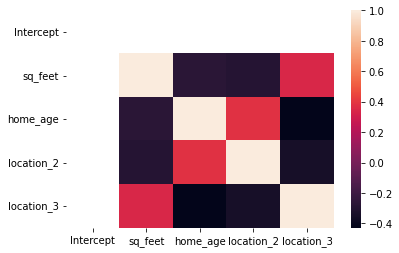

In [ ]:
train = pd.concat([y_train, X_train], axis=1)
columns_names = ['price', 'const', 'sq_feet','home_age', 'location_2', 'location_3']
train.columns = columns_names

formula = 'price ~ sq_feet+home_age+location_2+location_3'
y, X = dmatrices(formula, data=train, return_type='dataframe')

#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

#view VIF for each explanatory variable
print(vif)

cormat = X.corr()
round(cormat,2)
sns.heatmap(cormat);
plt.show()

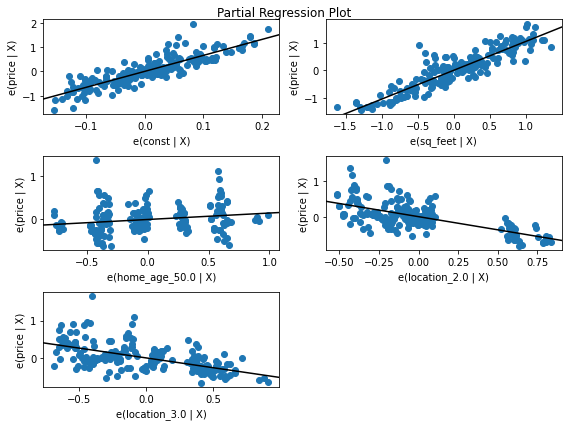

In [ ]:
fig = plt.figure(figsize=(8, 6))
plot_partregress_grid(stat_model, fig=fig)
plt.show()

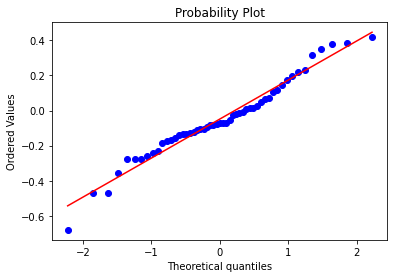

In [ ]:
residuals = np.array([])
for i, y in np.ndenumerate(y_test):
  residuals = np.append(residuals, y - y_pred[i])
stats.probplot(residuals, plot=plt)
plt.show()

Text(0.5, 1.0, 'Fit Values for Residuals: -0.05 and 0.22')

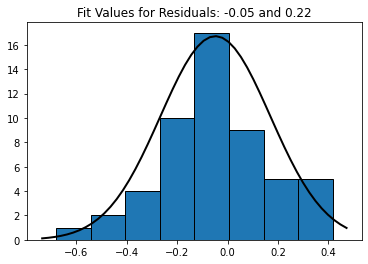

In [ ]:
mu, std = stats.norm.fit(residuals)

plt.hist(residuals, edgecolor = 'black', bins = 'sqrt')
# Plot the PDF.
xmin, xmax = plt.xlim()
bin_width = (xmax-xmin)/7
x = np.linspace(xmin, xmax, 50)
p = stats.norm.pdf(x, mu, std)

plt.plot(x, p*residuals.size*bin_width, 'k', linewidth=2)
title = "Fit Values for Residuals: {:.2f} and {:.2f}".format(mu, std)
plt.title(title)

Text(0.5, 1.0, 'Residual Boxplot')

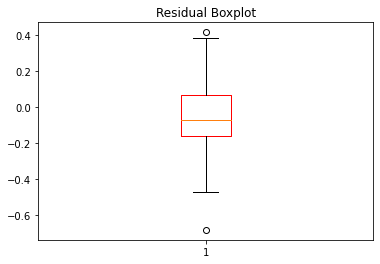

In [ ]:
plt.boxplot(residuals, boxprops=dict(color='red'))
plt.title('Residual Boxplot')

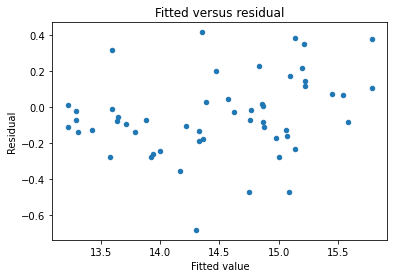

In [ ]:
residuals = np.array([])
fitted = np.array([])
for i, y in np.ndenumerate(y_test):
  residuals = np.append(residuals, y - y_pred[i])
  fitted = np.append(fitted, y_pred[i])

df_residuals = {}
df_residuals['x'] = fitted
df_residuals['y'] = residuals
df_residuals = pd.DataFrame(df_residuals)

ax = df_residuals.plot.scatter('x', 'y')
ax.set_title('Fitted versus residual')
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
plt.show()

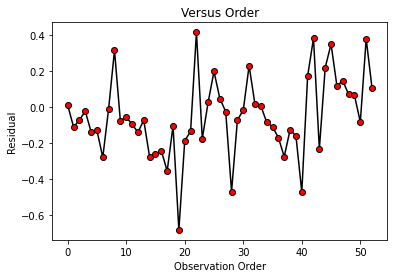

In [ ]:
keyed_values = sorted(zip(df_residuals['x'], df_residuals['y']), key=lambda x: x[ 0])
sorted_residuals = [x[ 1] for x in keyed_values]
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(sorted_residuals, 'ro-', c='black', mfc='red')
ax.set_title('Versus Order')
ax.set_xlabel('Observation Order')
ax.set_ylabel('Residual')
plt.show()

In [ ]:
df_actual_v_predicted = {}
df_actual_v_predicted['Sq Ft'] = np.exp(X_test.sq_feet).round(0).astype(int)
df_actual_v_predicted['Actual'] = np.exp(y_test).round(0).astype(int)
df_actual_v_predicted['Predicted'] = np.exp(y_pred).round(0).astype(int)
df_actual_v_predicted['Difference'] = (np.exp(y_test).round(0).astype(int) - np.exp(y_pred).round(0).astype(int))
df_actual_v_predicted = pd.DataFrame(df_actual_v_predicted)

In [ ]:
pd.set_option('max_colwidth', 600)
display(df_actual_v_predicted.sort_values(by='Actual'))

,Sq Ft,Actual,Predicted,Difference
200,899,499000,556080,-57080
71,968,525000,601285,-76285
190,504,550000,591076,-41076
245,894,560000,552812,7188
5,504,579000,591076,-12076
251,1321,595000,676271,-81271
219,764,599000,790944,-191944
43,1612,775000,834646,-59646
39,1353,799000,804538,-5538
184,1335,799999,844556,-44557
